In [141]:
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pandas import read_csv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32

In [142]:
class MNISTDataset(Dataset):
    def __init__(self, path: Path, train=True):
        self.X = torch.Tensor(read_csv(path, dtype="float32").to_numpy())
        self.train = train
        if train:
            self.y = self.X[:, 0]
            self.X = self.X[:, 1:]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index: int):
        if self.train:
            return self.X[index], self.y[index].long()
        else:
            return self.X[index]

In [143]:
trainset = MNISTDataset(Path("data") / "train.csv")
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

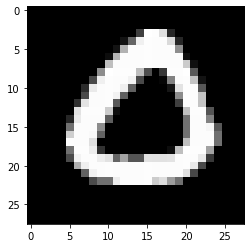

In [144]:
image, label = iter(trainloader).next()
plt.imshow(image[0].reshape((28, 28)), cmap="gray")

In [145]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, X: torch.Tensor):
        X = X.view(-1, 1, 28, 28)
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = F.adaptive_avg_pool2d(X, 1)
        return X.view(-1, X.size(1))
    
net = Net().to(device)

In [146]:
net(iter(trainloader).next()[0].to(device))

tensor([[7.3124e-01, 5.2673e+00, 1.0373e+00, 1.1032e+00, 6.9394e+00, 7.8985e-01,
         5.5129e-01, 1.4933e+00, 2.5432e-01, 3.4153e+00],
        [4.1353e-01, 2.6992e+00, 4.8907e-01, 6.0092e-01, 2.3013e+00, 5.1326e-01,
         1.5023e-01, 6.7445e-01, 1.6483e-01, 1.1642e+00],
        [3.7290e-01, 3.9151e+00, 2.7705e-02, 1.0633e+00, 5.4372e+00, 8.3794e-01,
         1.8770e-01, 1.9544e+00, 1.7778e+00, 1.1357e+00],
        [1.1565e+00, 4.3307e+00, 7.5646e-01, 1.2858e-01, 7.9774e+00, 1.1532e+00,
         2.5366e-01, 2.0896e+00, 1.5981e+00, 2.3173e+00],
        [1.4382e+00, 4.0402e+00, 5.8557e-01, 2.5855e-01, 5.9482e+00, 9.0887e-01,
         2.1324e-01, 6.1309e-01, 5.5935e-01, 2.3962e+00],
        [8.7856e-01, 4.6826e+00, 6.6722e-01, 1.1175e+00, 6.7052e+00, 5.9742e-01,
         1.2589e+00, 1.1870e+00, 6.1837e-01, 1.1972e+00],
        [8.1678e-01, 4.7267e+00, 6.7857e-01, 6.5097e-01, 6.2867e+00, 1.3328e+00,
         5.2711e-01, 1.2431e+00, 1.1619e+00, 2.3371e+00],
        [8.5689e-01, 4.9188

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [148]:
for epoch in range(10):
    running_loss = 0.0
    
    for images, labels in iter(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_size
    print(running_loss / len(trainset))

0.8151177546410333
0.3647823683080219
0.2834104461442857
0.24583148183141437
0.22271391439437865
0.20606740959485373
0.1870752580165863
0.17999277562186833
0.16850083267121088
0.1615918190365746


In [149]:
torch.save(net.state_dict(), Path("model") / "mnist_net.pt")

In [150]:
testset = MNISTDataset(Path("data") / "test.csv", train=False)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)

net.eval()
predicted = []
for images in iter(testloader):
    images = images.to(device)
    output = net(images)
    predicted += torch.argmax(output, dim=1).tolist()

In [151]:
import csv
with open("submission.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["ImageId", "Label"])
    for i, label in enumerate(predicted, 1):
        writer.writerow([i, label])

